In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms

/home/vamsi/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("osunlp/MagicBrush")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 8807
    })
    dev: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 528
    })
})

In [4]:
print(ds['train'][0].keys())

dict_keys(['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'])


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(device)

cuda


In [8]:
from transformers import CLIPProcessor, CLIPModel
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embeddings(source_img, instruction_text):
    # Process the source image and instruction text for CLIP
    inputs = clip_processor(text=instruction_text, images=source_img, return_tensors="pt", padding=True)
    
    # Move inputs to the GPU
    inputs = {key: value for key, value in inputs.items()}
    
    image_embeddings = clip_model.get_image_features(inputs['pixel_values'])  # (batch_size, embedding_size)
    text_embeddings = clip_model.get_text_features(inputs['input_ids'])  # (batch_size, embedding_size)
    
    return image_embeddings, text_embeddings

In [9]:
import io
class MagicBrushDataset(Dataset):
    def __init__(self, split='train', fraction=1.0):
        if fraction<1.0:
            split = f"{split}[:{int(fraction * 100)}%]"
        self.dataset = load_dataset("osunlp/MagicBrush", split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the item from the dataset
        item = self.dataset[idx]

        text = item['instruction']
        if isinstance(item['source_img'], Image.Image):  # Already a PIL image
            image = item['source_img'].convert('RGB')
        else:
            raise ValueError(f"Unexpected type for 'source_img': {type(item['source_img'])}")
        
        # get image and text embeddings
        img_embedding, text_embedding = get_clip_embeddings(image, text)
        
        if isinstance(item['mask_img'], Image.Image):  # Check if already a PIL image
            mask = item['mask_img'].convert('L')
        else:
            raise ValueError(f"Unexpected type for 'mask': {type(item['mask'])}")

        mask = transforms.Resize((224, 224))(mask)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0).float()  # Binary mask
        mask = mask.squeeze(0)
        text_embedding = text_embedding.detach()
        img_embedding = img_embedding.detach()
        mask = mask.detach()
        return text_embedding.squeeze(0), img_embedding.squeeze(0), mask

In [10]:
train_dataset = MagicBrushDataset(split='train', fraction=0.5)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)

In [11]:
test_dataset = MagicBrushDataset(split='dev')
test_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

In [12]:
print(len(train_dataset), len(test_dataset))

4404 528


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights


class CLIP_MaskPredictor(nn.Module):
    def __init__(self):
        super(CLIP_MaskPredictor, self).__init__()
        self.mask_prediction_network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [32, 16, 768, 768]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [32, 16, 384, 384]
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # [32, 32, 384, 384]
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1),                  # [32, 32, 192, 192]

            # nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
            nn.AdaptiveAvgPool2d((224, 224)),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img, text): 
        cross_product = torch.bmm(img.unsqueeze(2), text.unsqueeze(1))  # Shape: [batch_size, 768, 768]
        cross_product = cross_product.unsqueeze(1)
        # print(2,'-',cross_product.shape)
        out = self.mask_prediction_network(cross_product)

        # Return the logits (no sigmoid here, BCEWithLogitsLoss will handle it)
        return out.squeeze(1)  # Shape: [batch_size, 224, 224]

model = CLIP_MaskPredictor().to(device)
print(device)

cuda


In [15]:
model=torch.load('clip_maskpredictor.pth').to(device)

/tmp/ipykernel_51933/3264504686.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model=torch.load('clip_maskpredictor.pth').to(device)


In [55]:
from tqdm import tqdm

criterion = nn.BCELoss()  # Combine sigmoid and BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        # Move data to device
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]
        # print("embeddings are ready", text_embedding)
        # Zero the gradients
        optimizer.zero_grad()
        # print('optimizer is ready')
        # Forward pass
        pred_mask = model(img, text_embedding)  
        loss = criterion(pred_mask, gt_mask)
        # print("loss:", loss)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    torch.save(model, "clip_maskpredictor.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

100%|██████████| 276/276 [10:41<00:00,  2.32s/it]


Epoch [1/100], Loss: 0.4165


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [2/100], Loss: 0.4168


100%|██████████| 276/276 [10:44<00:00,  2.34s/it]


Epoch [3/100], Loss: 0.4157


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [4/100], Loss: 0.4152


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [5/100], Loss: 0.4153


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [6/100], Loss: 0.4152


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [7/100], Loss: 0.4157


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [8/100], Loss: 0.4148


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [9/100], Loss: 0.4155


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [10/100], Loss: 0.4146


100%|██████████| 276/276 [10:29<00:00,  2.28s/it]


Epoch [11/100], Loss: 0.4154


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [12/100], Loss: 0.4154


100%|██████████| 276/276 [10:27<00:00,  2.27s/it]


Epoch [13/100], Loss: 0.4151


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [14/100], Loss: 0.4151


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [15/100], Loss: 0.4151


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [16/100], Loss: 0.4150


100%|██████████| 276/276 [10:29<00:00,  2.28s/it]


Epoch [17/100], Loss: 0.4150


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [18/100], Loss: 0.4149


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [19/100], Loss: 0.4151


100%|██████████| 276/276 [10:29<00:00,  2.28s/it]


Epoch [20/100], Loss: 0.4149


100%|██████████| 276/276 [10:28<00:00,  2.28s/it]


Epoch [21/100], Loss: 0.4149


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [22/100], Loss: 0.4152


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [23/100], Loss: 0.4150


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [24/100], Loss: 0.4147


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [25/100], Loss: 0.4146


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [26/100], Loss: 0.4148


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [27/100], Loss: 0.4150


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [28/100], Loss: 0.4150


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [29/100], Loss: 0.4157


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [30/100], Loss: 0.4148


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [31/100], Loss: 0.4150


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [32/100], Loss: 0.4146


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [33/100], Loss: 0.4150


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [34/100], Loss: 0.4157


100%|██████████| 276/276 [10:34<00:00,  2.30s/it]


Epoch [35/100], Loss: 0.4146


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [36/100], Loss: 0.4147


100%|██████████| 276/276 [10:38<00:00,  2.31s/it]


Epoch [37/100], Loss: 0.4149


100%|██████████| 276/276 [10:39<00:00,  2.32s/it]


Epoch [38/100], Loss: 0.4148


100%|██████████| 276/276 [10:39<00:00,  2.32s/it]


Epoch [39/100], Loss: 0.4155


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [40/100], Loss: 0.4146


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [41/100], Loss: 0.4152


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [42/100], Loss: 0.4147


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [43/100], Loss: 0.4147


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [44/100], Loss: 0.4147


100%|██████████| 276/276 [10:34<00:00,  2.30s/it]


Epoch [45/100], Loss: 0.4144


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [46/100], Loss: 0.4145


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [47/100], Loss: 0.4147


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [48/100], Loss: 0.4146


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [49/100], Loss: 0.4143


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [50/100], Loss: 0.4145


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [51/100], Loss: 0.4150


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [52/100], Loss: 0.4153


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [53/100], Loss: 0.4151


100%|██████████| 276/276 [10:38<00:00,  2.31s/it]


Epoch [54/100], Loss: 0.4144


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [55/100], Loss: 0.4146


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [56/100], Loss: 0.4142


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [57/100], Loss: 0.4149


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [58/100], Loss: 0.4147


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [59/100], Loss: 0.4144


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [60/100], Loss: 0.4147


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [61/100], Loss: 0.4141


100%|██████████| 276/276 [10:39<00:00,  2.32s/it]


Epoch [62/100], Loss: 0.4144


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [63/100], Loss: 0.4141


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [64/100], Loss: 0.4142


100%|██████████| 276/276 [10:34<00:00,  2.30s/it]


Epoch [65/100], Loss: 0.4145


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [66/100], Loss: 0.4147


100%|██████████| 276/276 [10:35<00:00,  2.30s/it]


Epoch [67/100], Loss: 0.4143


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [68/100], Loss: 0.4148


100%|██████████| 276/276 [10:37<00:00,  2.31s/it]


Epoch [69/100], Loss: 0.4159


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [70/100], Loss: 0.4149


100%|██████████| 276/276 [10:30<00:00,  2.29s/it]


Epoch [71/100], Loss: 0.4144


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [72/100], Loss: 0.4142


100%|██████████| 276/276 [10:36<00:00,  2.31s/it]


Epoch [73/100], Loss: 0.4145


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [74/100], Loss: 0.4150


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [75/100], Loss: 0.4146


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [76/100], Loss: 0.4143


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [77/100], Loss: 0.4143


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [78/100], Loss: 0.4143


100%|██████████| 276/276 [10:29<00:00,  2.28s/it]


Epoch [79/100], Loss: 0.4153


100%|██████████| 276/276 [10:30<00:00,  2.28s/it]


Epoch [80/100], Loss: 0.4154


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [81/100], Loss: 0.4142


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [82/100], Loss: 0.4145


100%|██████████| 276/276 [10:29<00:00,  2.28s/it]


Epoch [83/100], Loss: 0.4141


100%|██████████| 276/276 [10:30<00:00,  2.29s/it]


Epoch [84/100], Loss: 0.4149


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [85/100], Loss: 0.4143


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [86/100], Loss: 0.4143


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [87/100], Loss: 0.4143


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [88/100], Loss: 0.4144


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [89/100], Loss: 0.4145


100%|██████████| 276/276 [10:34<00:00,  2.30s/it]


Epoch [90/100], Loss: 0.4143


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [91/100], Loss: 0.4152


100%|██████████| 276/276 [10:30<00:00,  2.29s/it]


Epoch [92/100], Loss: 0.4142


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [93/100], Loss: 0.4146


100%|██████████| 276/276 [10:31<00:00,  2.29s/it]


Epoch [94/100], Loss: 0.4141


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [95/100], Loss: 0.4145


100%|██████████| 276/276 [10:32<00:00,  2.29s/it]


Epoch [96/100], Loss: 0.4146


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [97/100], Loss: 0.4146


100%|██████████| 276/276 [10:33<00:00,  2.30s/it]


Epoch [98/100], Loss: 0.4140


100%|██████████| 276/276 [10:33<00:00,  2.29s/it]


Epoch [99/100], Loss: 0.4144


100%|██████████| 276/276 [10:30<00:00,  2.29s/it]

Epoch [100/100], Loss: 0.4143


/tmp/ipykernel_51933/3135179851.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("clip_maskpredictor.pth")
  0%|          | 0/276 [00:00<?, ?it/s]

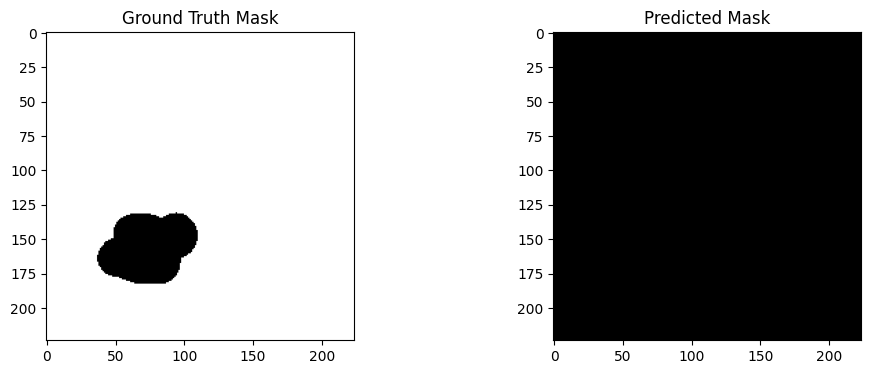

  0%|          | 1/276 [00:02<13:08,  2.87s/it]

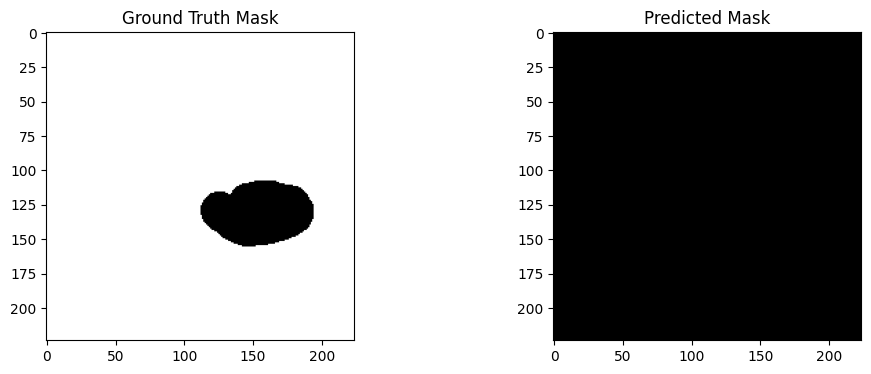

  1%|          | 2/276 [00:04<10:44,  2.35s/it]

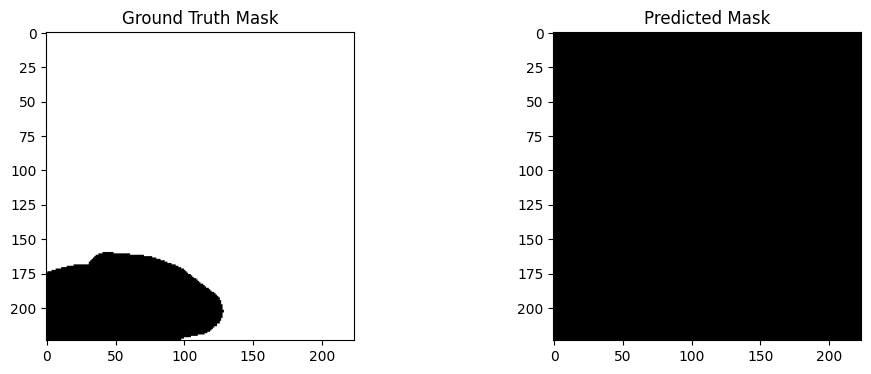

  1%|          | 3/276 [00:06<10:06,  2.22s/it]

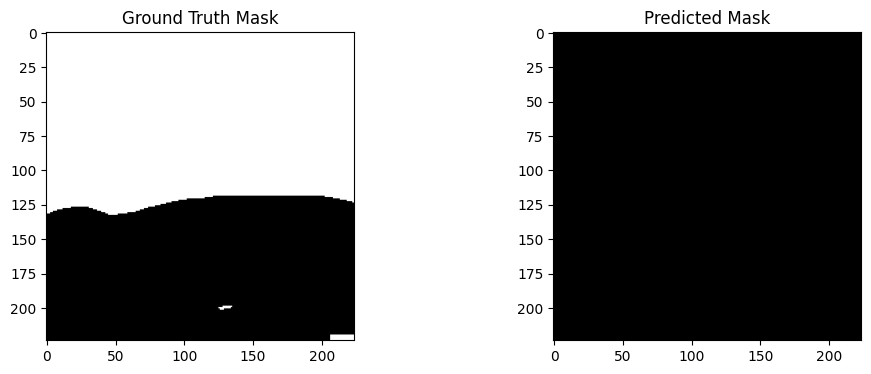

  1%|▏         | 4/276 [00:09<09:58,  2.20s/it]

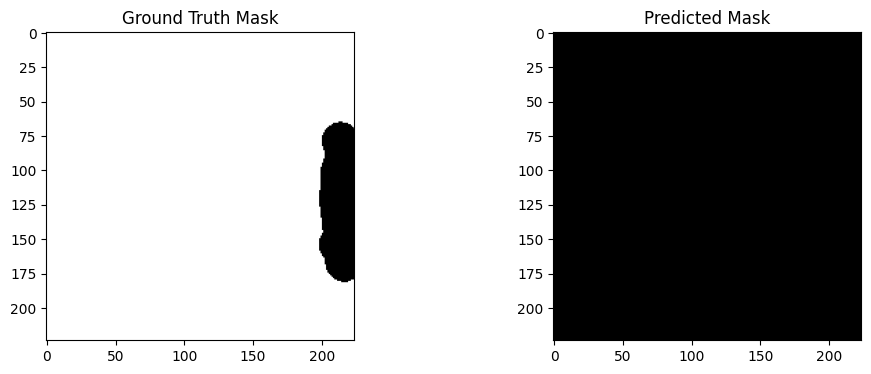

  2%|▏         | 5/276 [00:11<09:30,  2.11s/it]

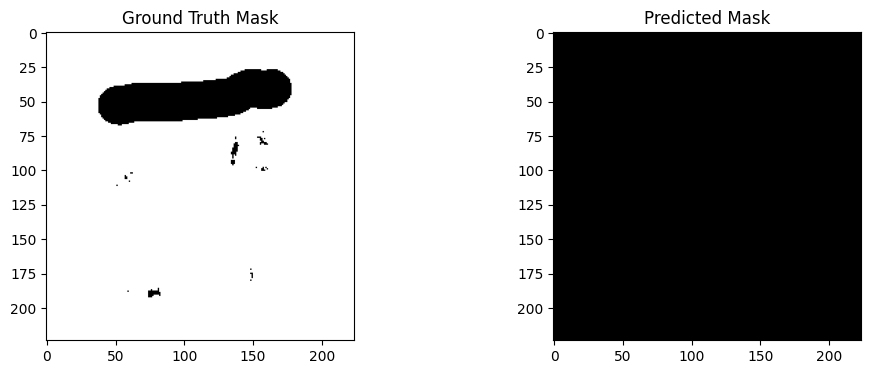

  2%|▏         | 6/276 [00:13<10:15,  2.28s/it]

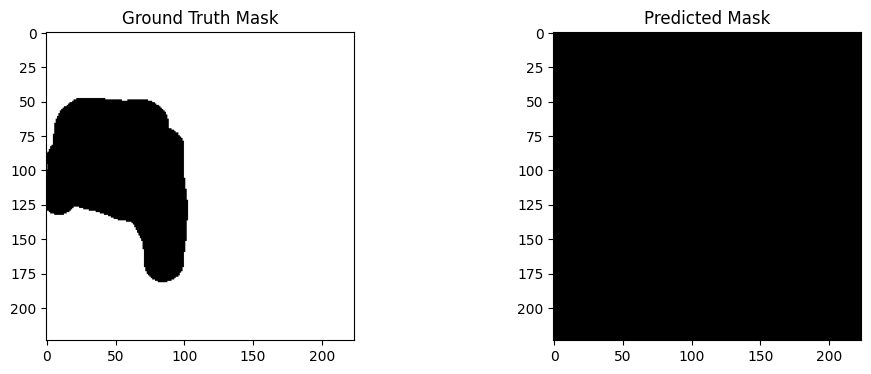

  3%|▎         | 7/276 [00:16<10:40,  2.38s/it]

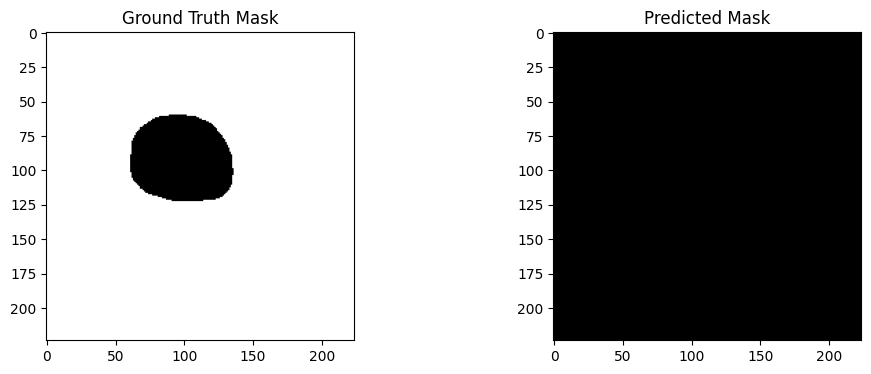

  3%|▎         | 8/276 [00:18<10:36,  2.38s/it]

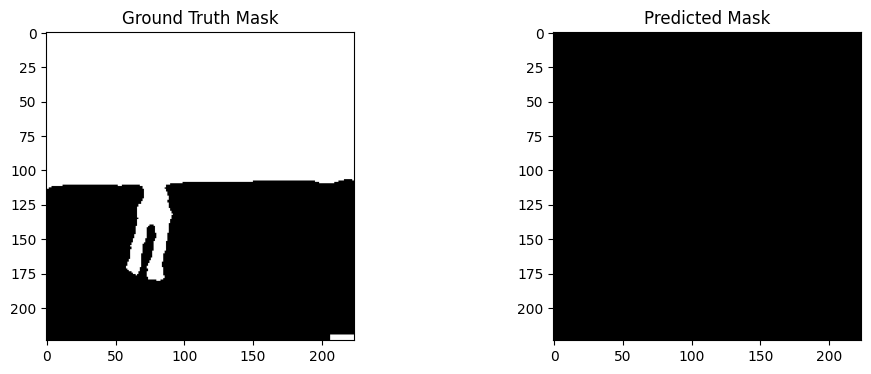

  3%|▎         | 9/276 [00:20<10:29,  2.36s/it]

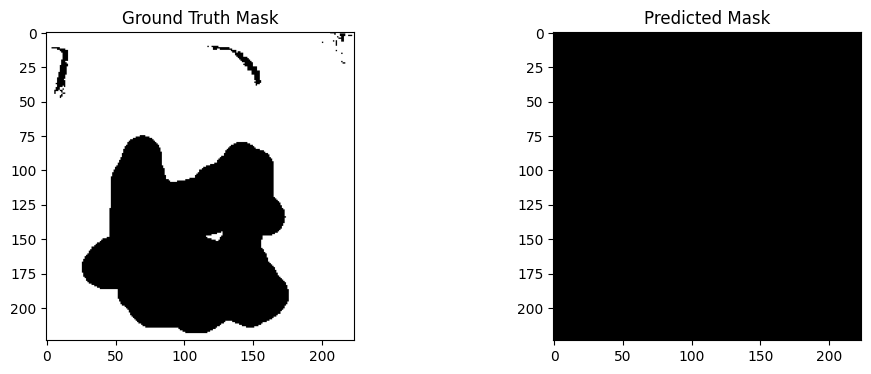

  4%|▎         | 10/276 [00:23<10:28,  2.36s/it]

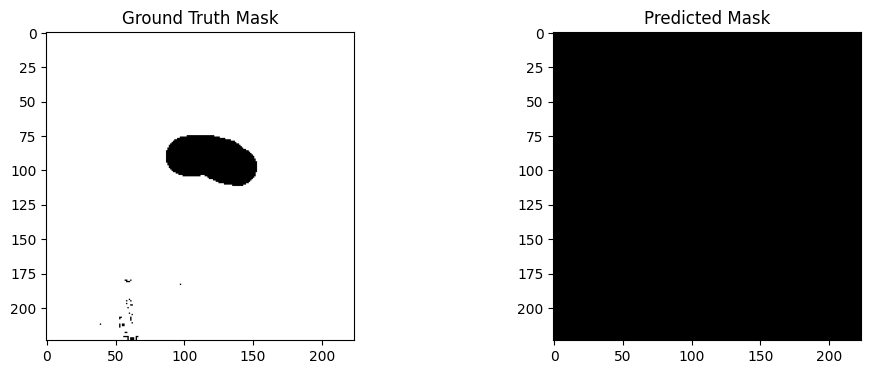

  4%|▍         | 11/276 [00:25<10:17,  2.33s/it]

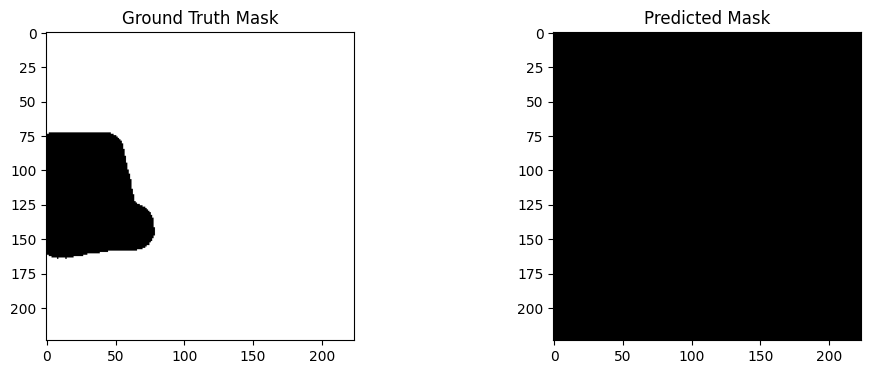

  4%|▍         | 12/276 [00:28<10:30,  2.39s/it]

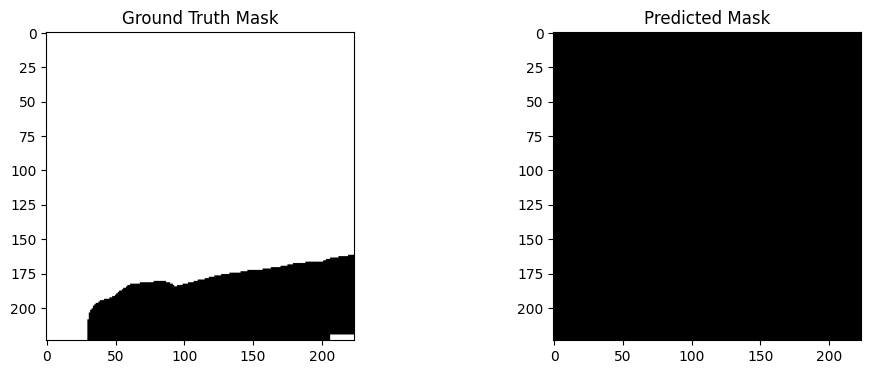

  5%|▍         | 13/276 [00:30<10:46,  2.46s/it]

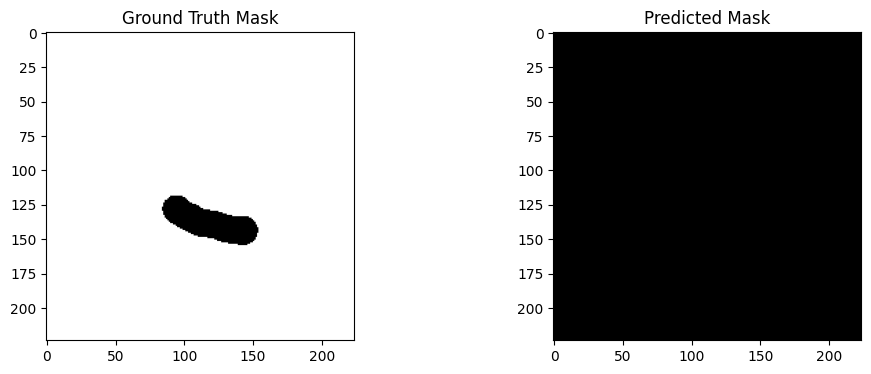

  5%|▌         | 14/276 [00:33<10:37,  2.43s/it]

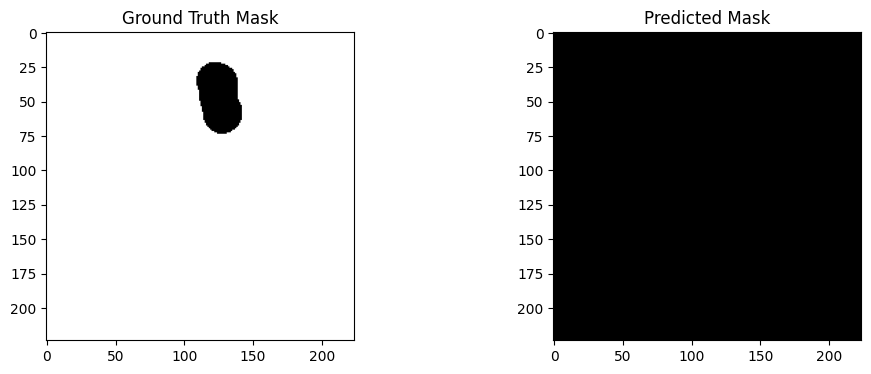

  5%|▌         | 15/276 [00:35<10:34,  2.43s/it]

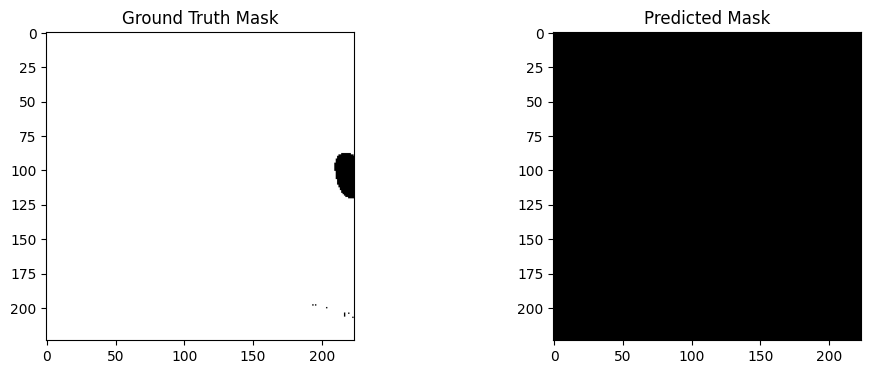

  6%|▌         | 16/276 [00:37<10:21,  2.39s/it]

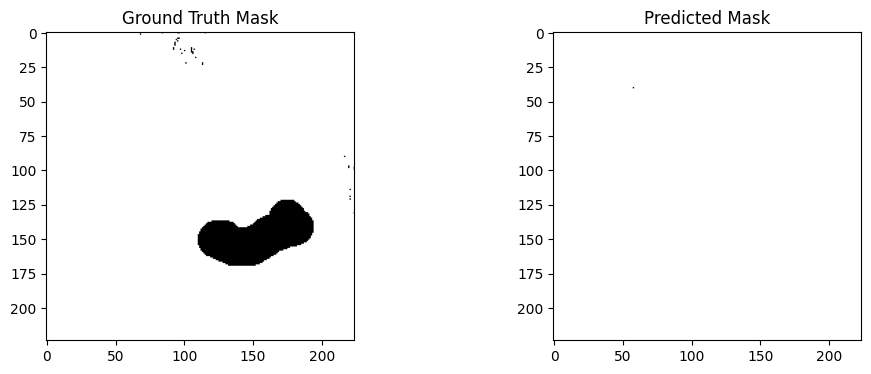

  6%|▌         | 17/276 [00:40<10:08,  2.35s/it]

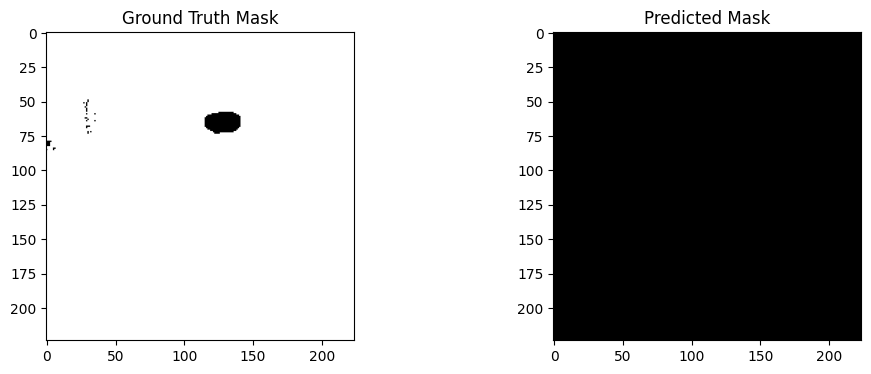

  7%|▋         | 18/276 [00:42<10:28,  2.44s/it]

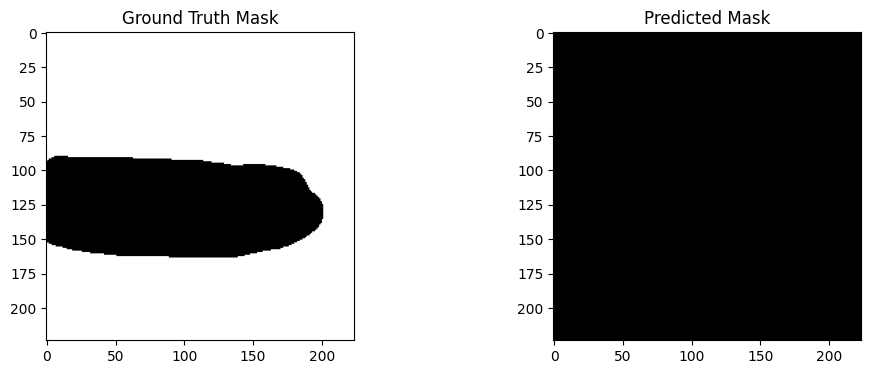

  7%|▋         | 19/276 [00:45<10:24,  2.43s/it]

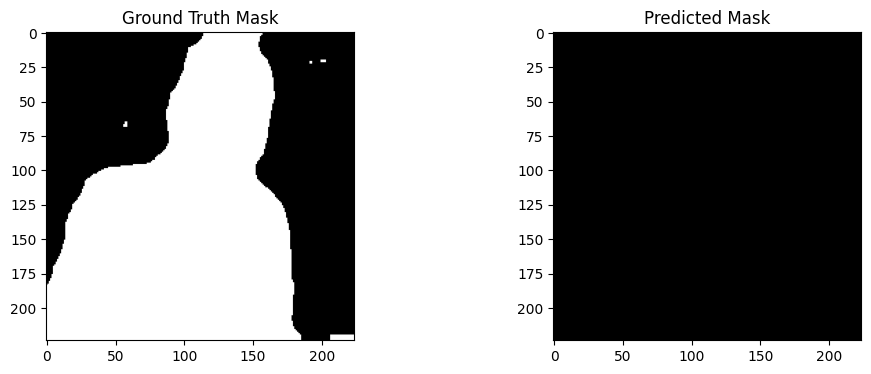

100%|██████████| 276/276 [09:23<00:00,  2.04s/it]


In [16]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("clip_maskpredictor.pth")
model.eval()  # Set model to evaluation mode

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float() 

        # Move data back to CPU for visualization
        img = img.cpu()
        gt_mask = gt_mask.cpu()
        pred_mask = pred_mask.cpu()

        if i < 20: 
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(gt_mask[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[0].set_title("Ground Truth Mask")
            axes[1].imshow(pred_mask[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[1].set_title("Predicted Mask")
            plt.show()


/tmp/ipykernel_51933/3284804790.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("clip_maskpredictor.pth")
  0%|          | 0/276 [00:00<?, ?it/s]

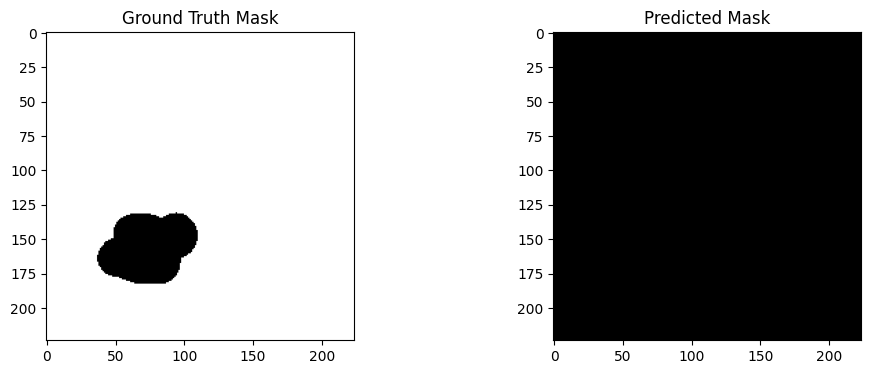

  0%|          | 1/276 [00:02<10:55,  2.39s/it]

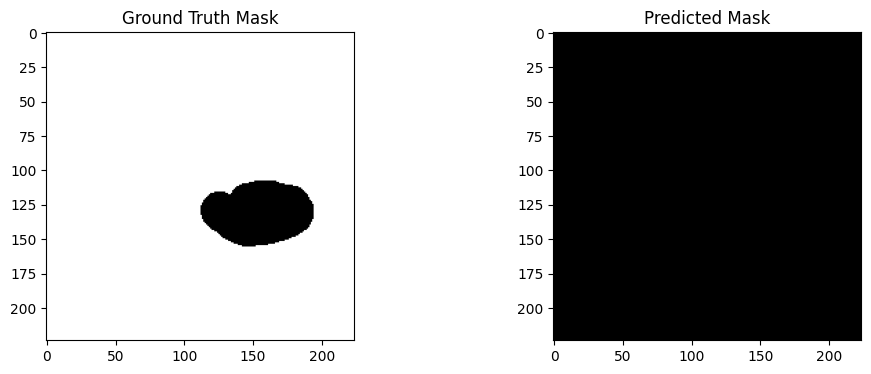

  1%|          | 2/276 [00:04<09:33,  2.09s/it]

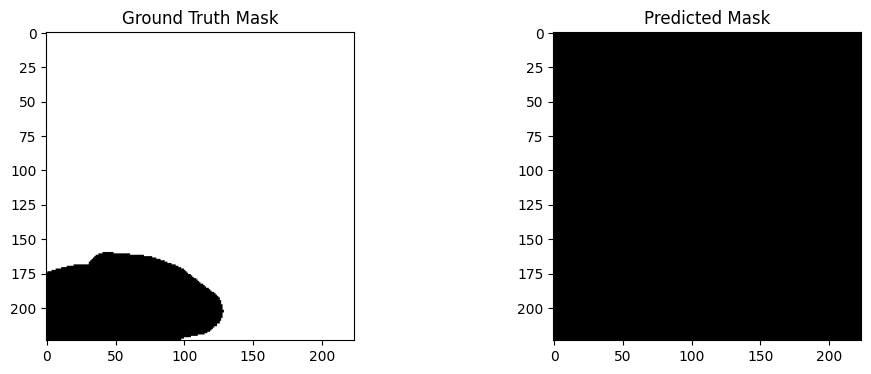

  1%|          | 3/276 [00:06<09:18,  2.05s/it]

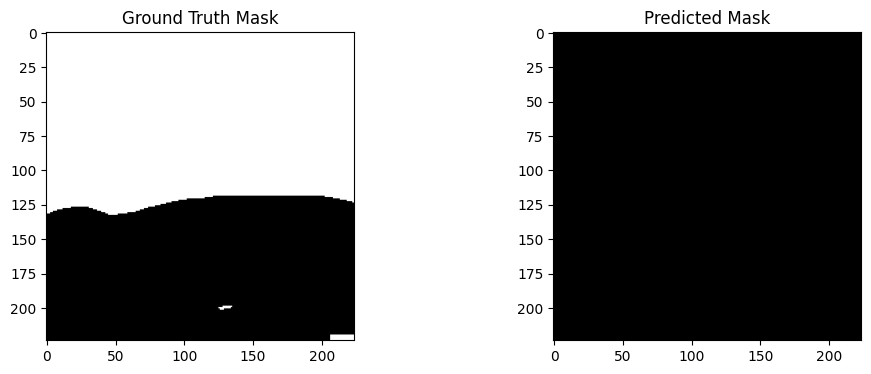

  1%|▏         | 4/276 [00:08<09:29,  2.09s/it]

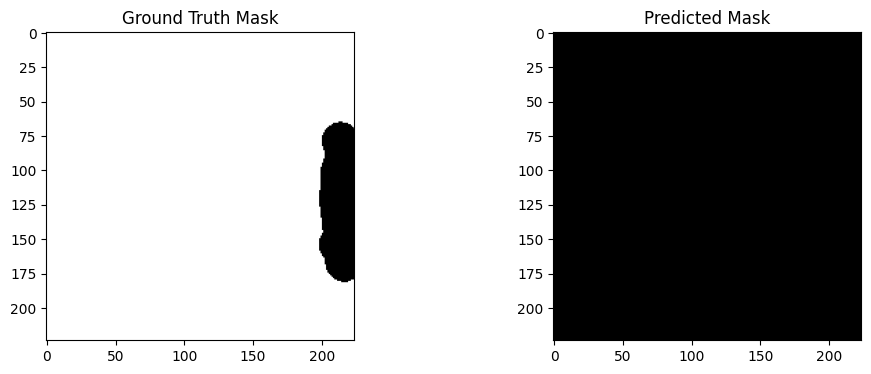

  2%|▏         | 5/276 [00:10<09:24,  2.08s/it]

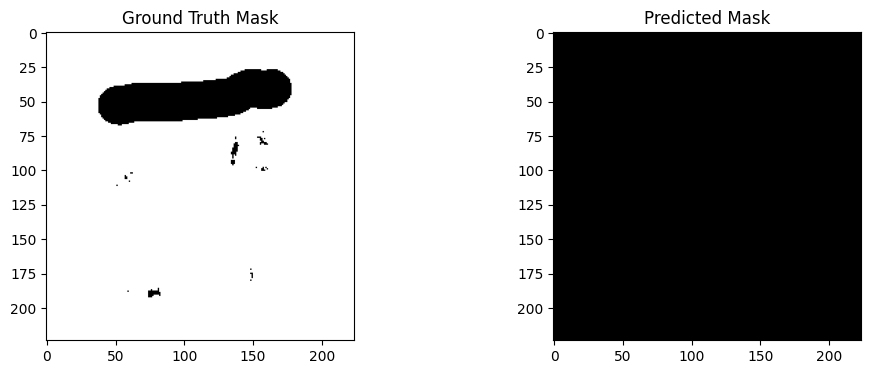

  2%|▏         | 6/276 [00:12<09:10,  2.04s/it]

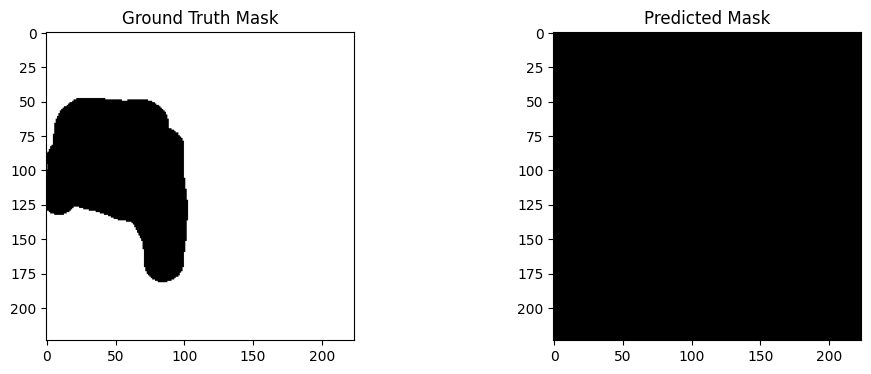

  3%|▎         | 7/276 [00:14<08:59,  2.01s/it]

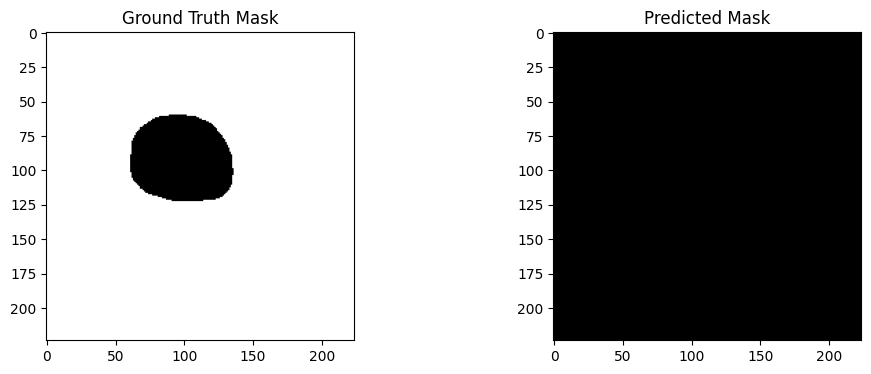

  3%|▎         | 8/276 [00:16<09:06,  2.04s/it]

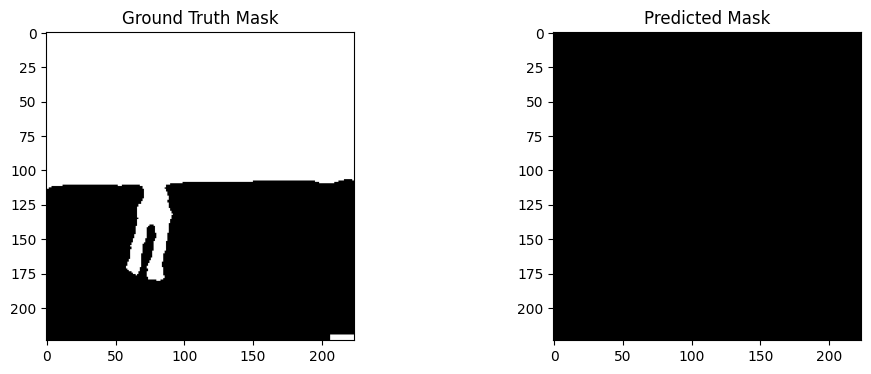

  3%|▎         | 9/276 [00:18<08:58,  2.02s/it]

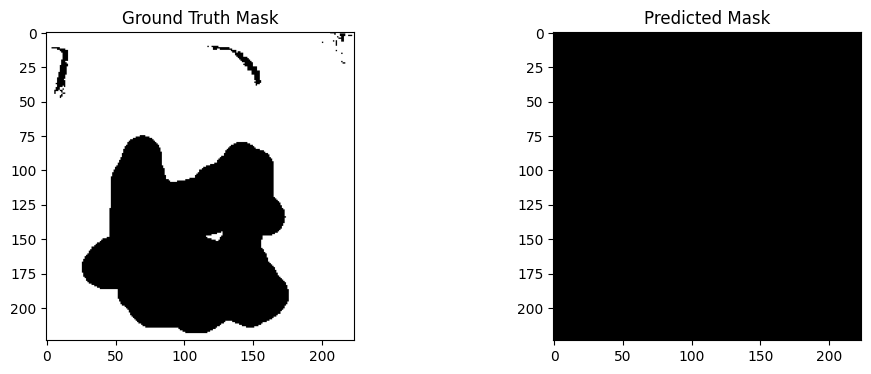

  4%|▎         | 10/276 [00:20<08:51,  2.00s/it]

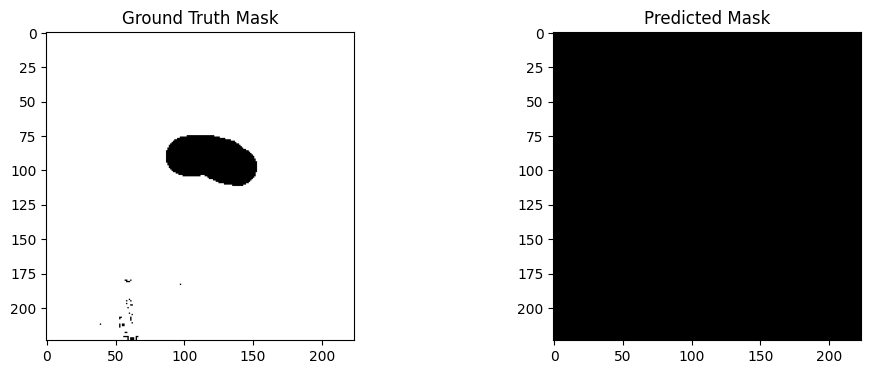

  4%|▍         | 11/276 [00:22<08:53,  2.01s/it]

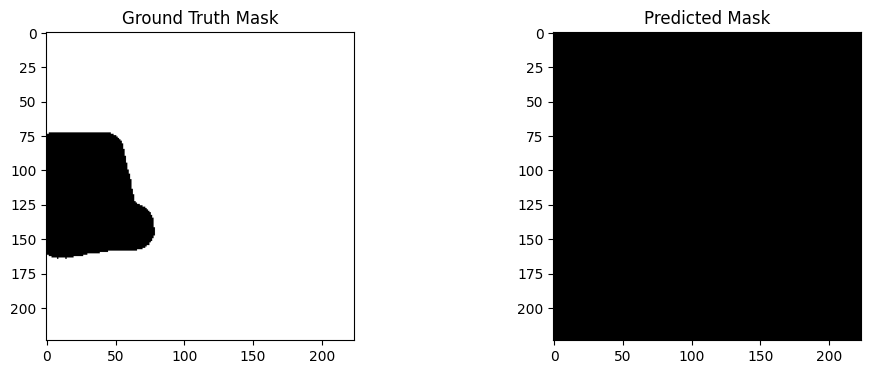

  4%|▍         | 12/276 [00:24<08:45,  1.99s/it]

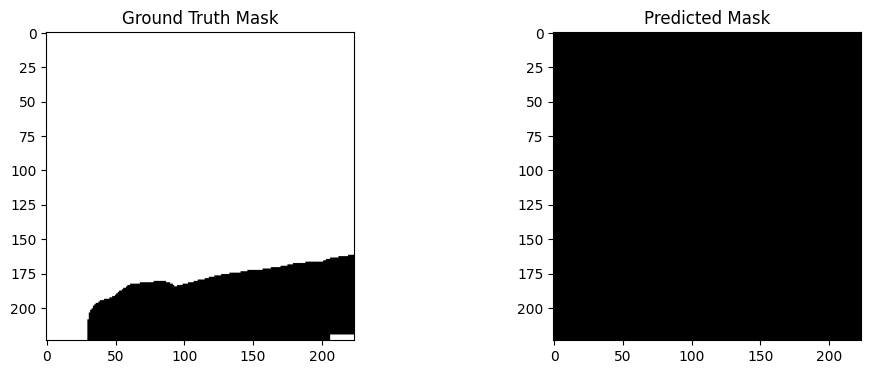

  5%|▍         | 13/276 [00:26<08:51,  2.02s/it]

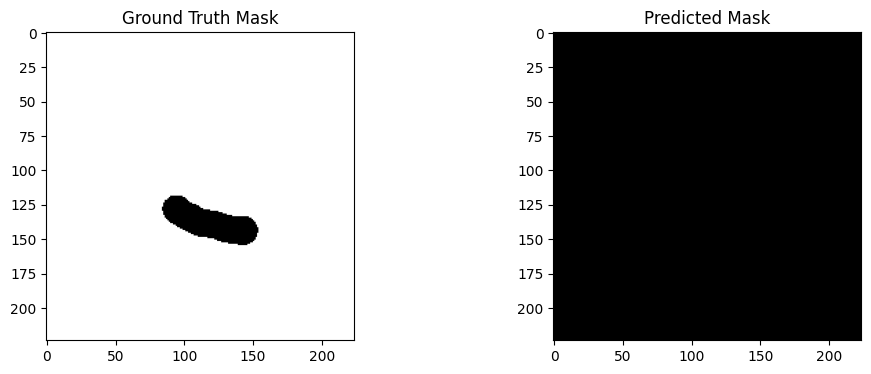

  5%|▌         | 14/276 [00:29<10:28,  2.40s/it]

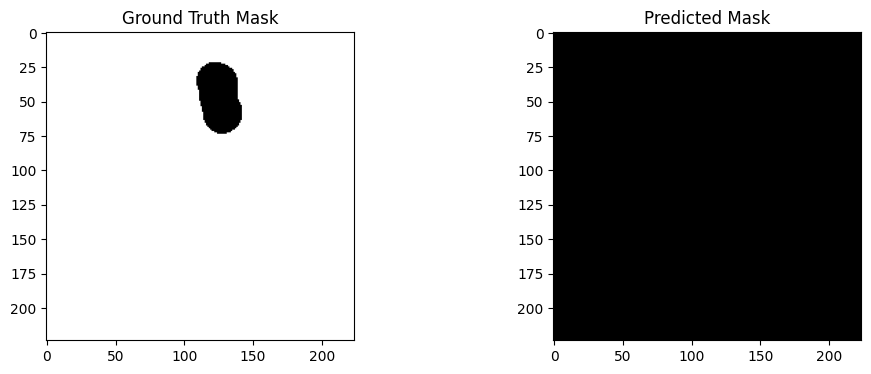

  5%|▌         | 15/276 [00:32<10:49,  2.49s/it]

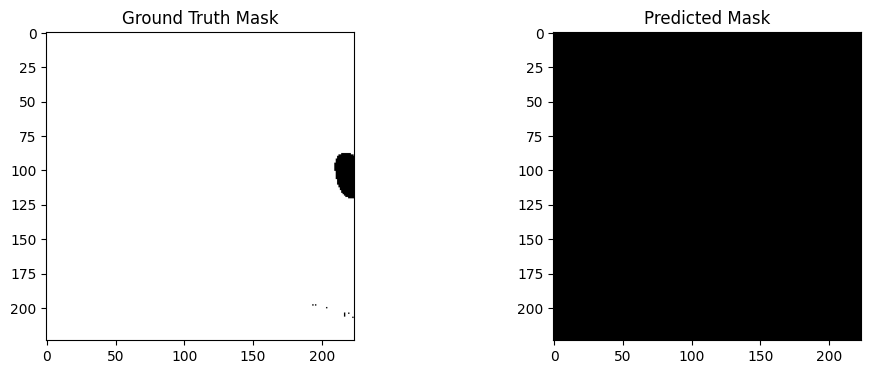

  6%|▌         | 16/276 [00:35<11:18,  2.61s/it]

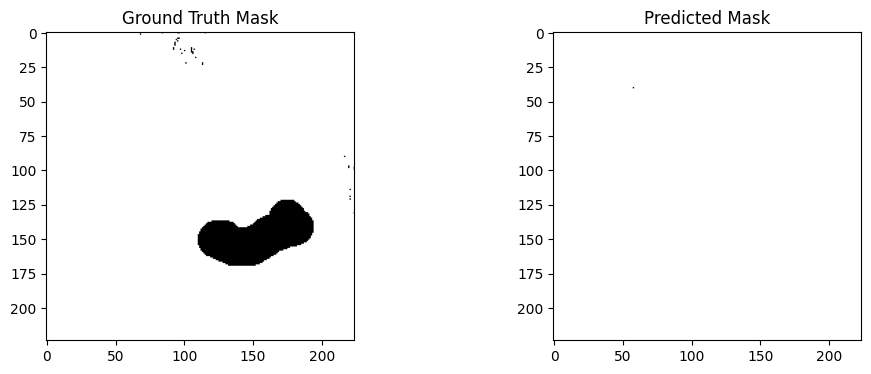

  6%|▌         | 17/276 [00:38<11:59,  2.78s/it]

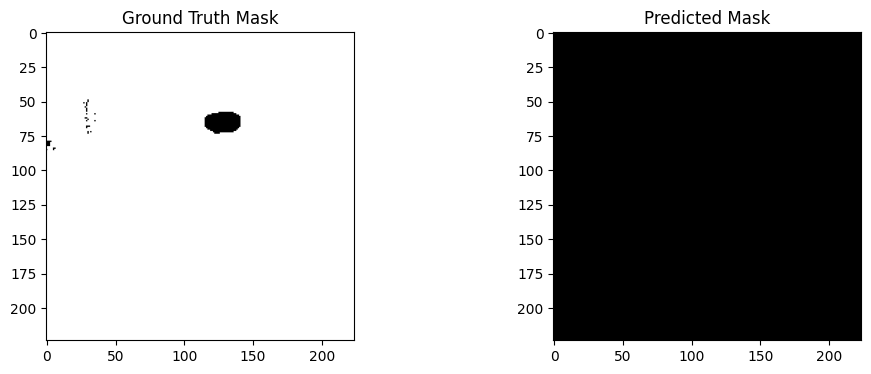

  7%|▋         | 18/276 [00:41<12:46,  2.97s/it]

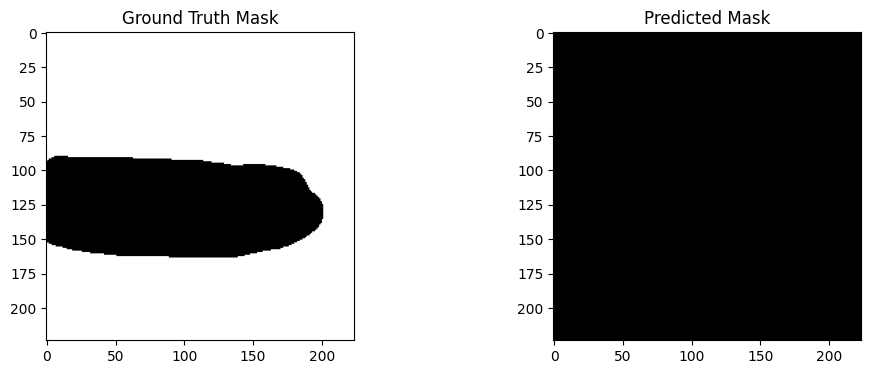

  7%|▋         | 19/276 [00:45<13:55,  3.25s/it]

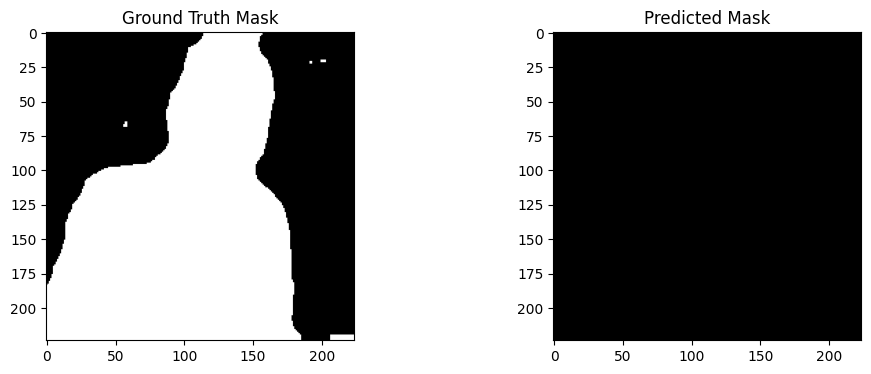

100%|██████████| 276/276 [13:35<00:00,  2.96s/it]

Average IoU: 0.0000


In [34]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("clip_maskpredictor.pth")
model.eval()  # Set model to evaluation mode

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]
        
        gt_masko=gt_mask.cpu()

        # Invert ground truth mask (black as foreground)
        gt_mask = 1 - gt_mask

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float()  # Binarize predictions
        pred_masko = pred_mask.cpu()
        pred_mask = 1 - pred_mask  # Invert predicted mask (black as foreground)
   
        

        # Calculate IoU for each sample in the batch
        intersection = (pred_mask * gt_mask).sum(dim=(1, 2))
        
        union = (pred_mask + gt_mask).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero

        iou_sum += iou.sum().item()  # Accumulate batch IoU
        total_samples += iou.size(0)  # Accumulate total number of samples


        # Visualization for the first 20 samples
        if i < 20:
            img = img.cpu()
            gt_mask = gt_mask.cpu()
            pred_mask = pred_mask.cpu()
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(gt_masko[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[0].set_title("Ground Truth Mask")
            axes[1].imshow(pred_masko[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[1].set_title("Predicted Mask")
            plt.show()

# Calculate average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")
